In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
data = pd.read_csv(r"C:\Users\anant\Downloads\transactions.csv")
print(data)

                           Transaction ID            Timestamp  \
0    4d3db980-46cd-4158-a812-dcb77055d0d2  2024-06-22 04:06:38   
1    099ee548-2fc1-4811-bf92-559c467ca792  2024-06-19 06:04:49   
2    d4c05732-6b1b-4bab-90b9-efe09d252b99  2024-06-04 04:56:09   
3    e8df92ee-8b04-4133-af5a-5f412180c8ab  2024-06-09 09:56:07   
4    e7d675d3-04f1-419c-a841-7a04662560b7  2024-06-25 08:38:19   
..                                    ...                  ...   
995  843d87b5-902e-4336-9438-aa76d74e13e4  2024-07-03 23:15:06   
996  2dbbb577-4617-44b1-9a51-5fdf18ebb2ab  2024-06-15 15:42:57   
997  7c38e684-5968-432e-8acb-5bbe0f718fad  2024-06-18 17:27:37   
998  27624b55-fd6d-45ce-bbc5-0c2958d48865  2024-06-05 21:57:36   
999  b792bf64-2047-4435-aac1-27ee95b134d6  2024-06-21 15:52:40   

            Sender Name          Sender UPI ID   Receiver Name  \
0             Tiya Mall      4161803452@okaxis  Mohanlal Golla   
1       Mohanlal Bakshi      8908837379@okaxis  Mehul Sankaran   
2        

In [4]:
# Data Preprocessing
print("Initial Data Overview:")
print(data.info())
print(data.describe())

# Drop duplicates and reset index
data = data.drop_duplicates().reset_index(drop=True)
print("\nDuplicates removed and indices reset.\n")

# Fill missing values
data['Amount (INR)'] = data['Amount (INR)'].fillna(data['Amount (INR)'].mean())
data['Sender Name'] = data['Sender Name'].fillna(data['Sender Name'].mode()[0])
data['Timestamp'] = data['Timestamp'].fillna(data['Timestamp'].mode()[0])
data['Status'] = data['Status'].fillna(data['Status'].mode()[0])
data['Receiver Name'] = data['Receiver Name'].fillna(data['Receiver Name'].mode()[0])
data['Receiver UPI ID'] = data['Receiver UPI ID'].fillna(data['Receiver UPI ID'].mode()[0])

# Convert Timestamp to datetime format
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Transaction ID   1000 non-null   object 
 1   Timestamp        1000 non-null   object 
 2   Sender Name      1000 non-null   object 
 3   Sender UPI ID    1000 non-null   object 
 4   Receiver Name    1000 non-null   object 
 5   Receiver UPI ID  1000 non-null   object 
 6   Amount (INR)     1000 non-null   float64
 7   Status           1000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 62.6+ KB
None
       Amount (INR)
count   1000.000000
mean    4999.022930
std     2873.484534
min       28.520000
25%     2521.620000
50%     4951.435000
75%     7315.835000
max     9993.060000

Duplicates removed and indices reset.



In [5]:
# Feature Engineering
data['Day'] = data['Timestamp'].dt.day
data['Hour'] = data['Timestamp'].dt.hour
data['Weekday'] = data['Timestamp'].dt.weekday
data['Month'] = data['Timestamp'].dt.month

In [6]:
# Transaction velocity: Number of transactions in the last hour
data['Transaction_Velocity'] = data.groupby('Sender UPI ID')['Timestamp'].transform(lambda x: x.diff().dt.seconds / 3600).fillna(0)

In [7]:
# Drop unnecessary columns but retain UPI IDs
columns_to_drop = ['Transaction ID', 'Timestamp', 'Sender Name', 'Receiver Name']
data = data.drop(columns=columns_to_drop, axis=1)

In [8]:
# Encode categorical variables
le = LabelEncoder()
data['Status'] = le.fit_transform(data['Status'])

In [9]:
# Assuming fraud labels are provided in the dataset
# Otherwise, we need a more complex logic to label fraud cases
# We use a dummy fraud label here for demonstration purposes
np.random.seed(42)
data['is_fraud'] = np.random.choice([0, 1], size=len(data), p=[0.98, 0.02])

# Remove constant features
constant_features = [col for col in data.columns if data[col].nunique() == 1]
data = data.drop(columns=constant_features)

# Separate features and target variable
X = data.drop(['is_fraud', 'Sender UPI ID', 'Receiver UPI ID'], axis=1)
y = data['is_fraud']

# Ensure 'Transaction_Velocity' is in the dataframe before scaling
if 'Transaction_Velocity' in X.columns:
    scaler = StandardScaler()
    X[['Amount (INR)', 'Transaction_Velocity']] = scaler.fit_transform(X[['Amount (INR)', 'Transaction_Velocity']])
else:
    scaler = StandardScaler()
    X['Amount (INR)'] = scaler.fit_transform(X[['Amount (INR)']])

In [10]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [11]:
# Feature selection
selector = SelectKBest(f_classif, k=min(10, X_res.shape[1]))
X_res_selected = selector.fit_transform(X_res, y_res)

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res_selected, y_res, test_size=0.2, random_state=42)

In [13]:
# Train the model
clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [14]:
# Make predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

Confusion Matrix:
 [[176  30]
 [  4 183]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91       206
           1       0.86      0.98      0.92       187

    accuracy                           0.91       393
   macro avg       0.92      0.92      0.91       393
weighted avg       0.92      0.91      0.91       393


ROC AUC Score: 0.97


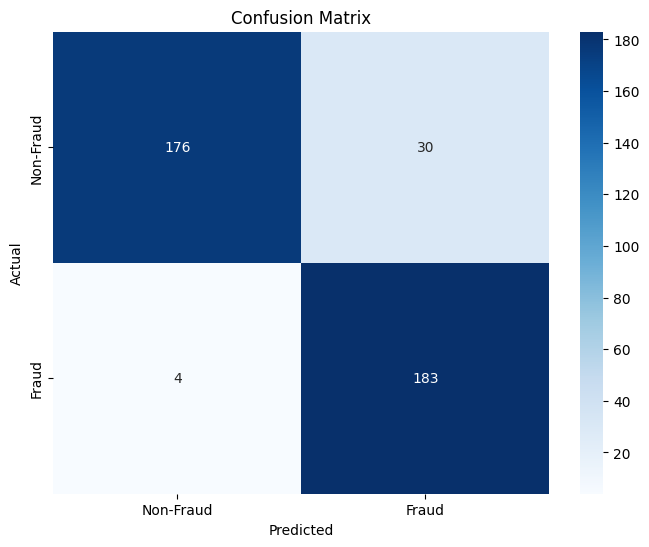

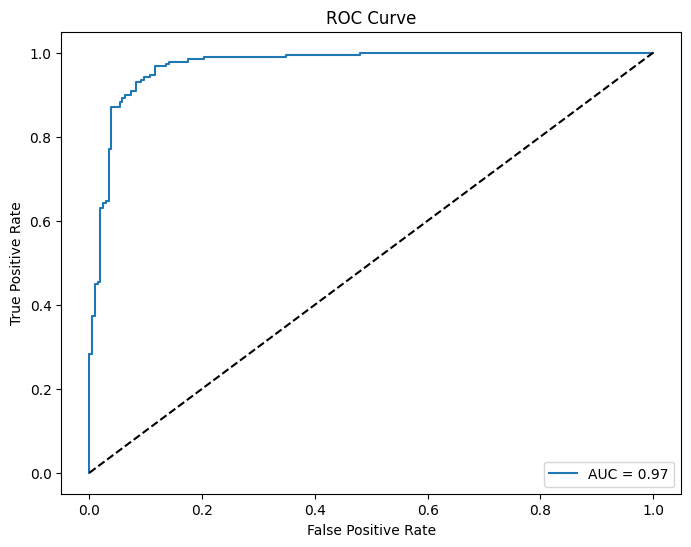

In [15]:
# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

print(f"\nROC AUC Score: {roc_auc:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [16]:
# Filter and display fraudulent transactions with reset indices
fraudulent_transactions = data[data['is_fraud'] == 1].reset_index(drop=True)
print("\nFraudulent Transactions with UPI IDs:")
print(fraudulent_transactions[['Sender UPI ID', 'Receiver UPI ID', 'Amount (INR)', 'is_fraud']])

# Number of Fraudulent Transactions
num_fraudulent_transactions = len(fraudulent_transactions)
print("\nNumber of Fraudulent Transactions:")
print(num_fraudulent_transactions)


Fraudulent Transactions with UPI IDs:
            Sender UPI ID        Receiver UPI ID  Amount (INR)  is_fraud
0   4253085716@okhdfcbank       1637805486@okybl       8454.42         1
1      0696746336@okicici     4958899985@okicici       9400.33         1
2      3738797628@okicici     9754546761@okicici       6515.54         1
3      6219061905@okicici  5320355616@okhdfcbank        411.54         1
4        8535051337@oksbi  7641417668@okhdfcbank        829.08         1
5        5368666334@oksbi      9047166627@okaxis       5686.93         1
6      7685201801@okicici     6090450630@okicici       1896.23         1
7        3879896652@oksbi  7139145427@okhdfcbank       1622.11         1
8   2310046011@okhdfcbank     4358999143@okicici       9865.26         1
9        8719404490@okybl       4641324854@oksbi       1489.67         1
10  6528937030@okhdfcbank       7704663274@okybl        384.39         1
11       6148327971@okybl     2696119622@okicici       2200.87         1
12     41869